In [1]:
#Number crunching, data and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

# Numerical integration
import sdeint
from scipy.integrate import solve_ivp

# Beatiful progress bars
from tqdm import tqdm, auto
from tqdm.notebook import tqdm

#load, save and compress data
import bz2
import pickle
import _pickle as cPickle

#other libraries
import pathlib

#umap
import umap

# Load the simulated data

In [71]:
file = pathlib.Path('trajectories.pbz2')
if file.exists ():
    print('Trajectories already calculated, loading and decompressing data...')
    rs_lam = bz2.BZ2File(file, 'rb')
    rs_lam = cPickle.load(rs_lam)

Trajectories already calculated, loading and decompressing data...


Let's arrange the data

In [72]:
lambda_list = []
sigma_list = []
trajectory_list = np.empty((125000,1001))

k = 0
for rs in rs_lam.keys():
    lambda_list = lambda_list + len(rs_lam[rs])*[rs[0]]
    sigma_list = sigma_list + len(rs_lam[rs])*[rs[1]]
    for i in range(5000):
        trajectory_list[k,:] = rs_lam[rs][i][:,0]
        k += 1

In [73]:
df1 = pd.DataFrame({'lambda': lambda_list, 'sigma': sigma_list})

In [74]:
df2 = pd.DataFrame(trajectory_list)

In [75]:
df = pd.concat([df1, df2], axis = 1)

Deletes redundant data

In [ ]:
del df1, df2, trajectory_list, sigma_list, lambda_list, traj_list, rs_lam, rs, i, k

I will start working with the less noisy data, keeping only the rows with sigma = 0.01

In [119]:
df1_001 = df[df['sigma'] == 0.01]
df1_001 = df1_001.drop('sigma', axis = 1)
y = df1_001['lambda']
X = df1_001.drop('lambda', axis = 1)

In [120]:
lambda_values = list(y.unique())
y[y == 10] = 4
y[y == 2.5] = 3
y[y == 1.0] = 2
y[y == 0.25] = 1
y[y == 0.1] = 0


y = y.astype('int')

Create a train, test split

In [114]:
from sklearn.model_selection import train_test_split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 42)

In [134]:
mapper = umap.UMAP(verbose = True).fit(X_train, y_train)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Fri Jun  5 09:51:09 2020 Finding Nearest Neighbors
Fri Jun  5 09:51:09 2020 Building RP forest with 12 trees
Fri Jun  5 09:51:11 2020 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
Fri Jun  5 09:51:14 2020 Finished Nearest Neighbor Search
Fri Jun  5 09:51:15 2020 Construct embedding
	completed  0  

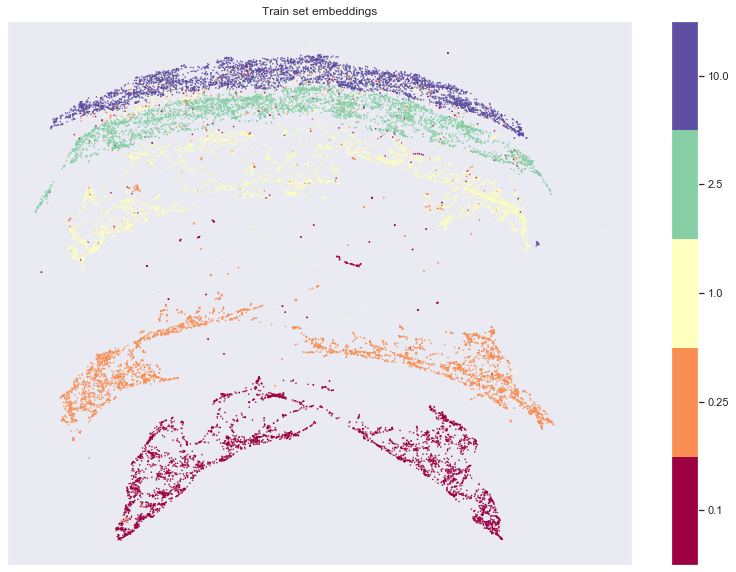

In [135]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s = 0.3, c = y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(lambda_values)
plt.title('Train set embeddings');

In [137]:
test_embedding = mapper.transform(X_test)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


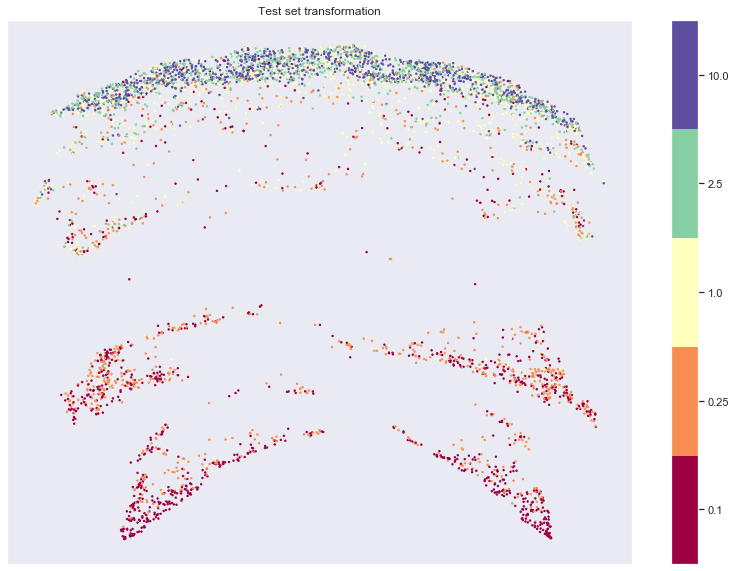

In [138]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*test_embedding.T, s=2, c=y_test, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(lambda_values)
plt.title('Test set transformation');

# Autoencoders

In [139]:
import tensorflow as tf
from tensorflow import keras

In [144]:
X_train_full= X_train
y_train_full = y_train
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [146]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [243]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (1001,)),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(30, activation="tanh"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="tanh", input_shape=[30]),
    keras.layers.Dense(1001, activation="tanh"),
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0098 - rounded_accuracy: 0.6684 - val_loss: 0.0010 - val_rounded_accuracy: 0.6770
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0010 - rounded_accuracy: 0.6768 - val_loss: 9.5392e-04 - val_rounded_accuracy: 0.6770
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 9.9334e-04 - rounded_accuracy: 0.6768 - val_loss: 9.3268e-04 - val_rounded_accuracy: 0.6770
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 9.7774e-04 - rounded_accuracy: 0.6768 - val_loss: 9.2063e-04 - val_rounded_accuracy: 0.6770
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 9.6990e-04 - rounded_accuracy: 0.6768 - val_loss: 9.1205e-04 - val_rounded_accuracy: 0.6770
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 9.6494e-04 - rounded_accuracy: 0.6768 - val_loss: 9.1224e-04 - val_rounded_accuracy: 0.6770
Epoch 7/20
469/4

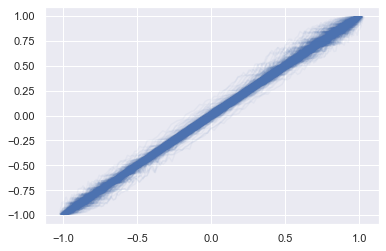

In [251]:
pred = stacked_ae.predict(X_valid)
for i in range(1, 500):
    plt.plot(X_valid.iloc[i], pred[i,:], 'b', alpha = 0.05)

In [257]:
encoding_valid = stacked_encoder.predict(X_valid)
encoding_train = stacked_encoder.predict(X_train)